In [1]:
import cv2
import matplotlib.pyplot as plt

camera_index = 0


In [2]:
cap = cv2.VideoCapture(camera_index, cv2.CAP_DSHOW) # this is the magic!


In [3]:
import pygame 
import os
pygame.init()
# Load the image

# Get available display info
display_info = pygame.display.get_desktop_sizes()
if len(display_info) < 2:
    print("Only one display detected. Cannot switch to a secondary screen.")
    sys.exit()

# Choose the secondary screen
secondary_screen_index = 0  # Index 1 corresponds to the second screen
secondary_screen_width, secondary_screen_height = display_info[secondary_screen_index]
# Set the environment variable to position the window on the secondary screen
os.environ['SDL_VIDEO_WINDOW_POS'] = f"{display_info[0][0]},{0}"  # Position at the start of the second screen

x = 0
y = 0
os.environ['SDL_VIDEO_WINDOW_POS'] = f"{x},{y}"

# Create a window with the secondary screen resolution


pygame 2.6.1 (SDL 2.28.4, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:

import numpy as np

scale = 1

pattern = np.zeros((secondary_screen_width//scale, secondary_screen_height//scale,3),dtype=np.uint8) 


In [5]:
pattern.shape

(1920, 1080, 3)

In [6]:
# import matplotlib.pyplot as plt
# plt.imshow(pattern)

In [7]:
# import cv2
# pattern = cv2.imread(r"D:\Users\danny\Downloads\my_pattern3.png")

In [8]:
import time
import tqdm 

screen = pygame.display.set_mode((secondary_screen_width, secondary_screen_height), pygame.FULLSCREEN, display=0)

caps_x = []
caps_y = []

jumps = 10

for i in tqdm.tqdm(range(0,pattern.shape[0],jumps)):
    pattern = np.zeros((secondary_screen_width//scale, secondary_screen_height//scale,3),dtype=np.uint8) 
    pattern[i,:,:] = 255


    screen = pygame.display.set_mode((secondary_screen_width, secondary_screen_height), pygame.FULLSCREEN, display=0)

    image_surface = pygame.surfarray.make_surface(pattern)
    screen.blit(image_surface, (0, 0))  # Draw the surface onto the screen
    pygame.display.update()  # Update the display
    time.sleep(0.1)
    for k in range(5):
        ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
    else:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        caps_x.append(frame)



for i in tqdm.tqdm(range(0,pattern.shape[1],jumps)):
    pattern = np.zeros((secondary_screen_width//scale, secondary_screen_height//scale,3),dtype=np.uint8) 
    pattern[:,i,:] = 255


    screen = pygame.display.set_mode((secondary_screen_width, secondary_screen_height), pygame.FULLSCREEN, display=0)

    image_surface = pygame.surfarray.make_surface(pattern)
    screen.blit(image_surface, (0, 0))  # Draw the surface onto the screen
    pygame.display.update()  # Update the display
    time.sleep(0.1)
    for k in range(5):
        ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
    else:
        # convert frame to grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        caps_y.append(frame)

100%|██████████| 108/108 [00:26<00:00,  4.11it/s]


In [9]:
# calculate the diffrance between every sequantial frame
caps_x = np.array(caps_x)
caps_x_diff = np.diff(caps_x.reshape(caps_x.shape[0],-1),axis=0)
assert (caps_x_diff.sum(-1) == 0).any() == False

caps_y = np.array(caps_y)
caps_y_diff = np.diff(caps_y.reshape(caps_y.shape[0],-1),axis=0)
assert (caps_y_diff.sum(-1) == 0).any() == False

In [10]:
positions = []
counter = 0
from tqdm import tqdm_notebook as tqdm

pbar = tqdm(total=len(caps_x)*len(caps_y))

for x in range(len(caps_x)):
    for y in range(len(caps_y)):   
        #find vertical line in caps_x and horizontal line in caps_y
        edges_x = cv2.Canny(caps_x[x], 50, 150, apertureSize=3)
        edges_y = cv2.Canny(caps_y[y], 50, 150, apertureSize=3)
        if edges_x.max() != 255 or edges_y.max() != 255:
            # print('bad frame')
            continue
        
        idx_x, idx_y = np.array(((edges_x == 255) * (edges_y == 255)).nonzero()).T.mean(0).astype(int)
        comb = edges_x + edges_y
        positions.append(((x * jumps,y * jumps),(idx_x,idx_y)))
        counter +=1 
        pbar.update(1)
        # if counter % 1000 == 0:
        #     plt.imshow(comb)
        #     plt.scatter(idx_y,idx_x)
        #     plt.show()


C:\Users\danny\AppData\Local\Temp\ipykernel_24916\1968144070.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(total=len(caps_x)*len(caps_y))


  0%|          | 0/20736 [00:00<?, ?it/s]

In [11]:
cv2.Canny(caps_x, 50, 150, apertureSize=3).shape

(192, 480)

In [12]:
original_points = np.array([x[0] for x in positions])
new_points = np.array([x[1] for x in positions])

H, _ = cv2.findHomography(original_points, new_points, cv2.RANSAC)


In [13]:
# pattern = np.zeros((secondary_screen_width//scale, secondary_screen_height//scale,3),dtype=np.uint8) 
# print(pattern.shape)
# # add eye to the pattern
# pattern[0,:,:] += 255
# pattern[-1,:,:] += 255
# pattern[:,0,:] += 255
# pattern[:,-1,:] += 255

pattern = cv2.imread(r"D:\Users\danny\Downloads\my_pattern3.png")

pattern = cv2.resize(pattern, (secondary_screen_width // 2, secondary_screen_height //2))

im_dst = cv2.warpPerspective(  pattern.transpose(1,0,2), H, (caps_x.shape[1], caps_x.shape[2]))

In [14]:
print(im_dst.shape)
print(caps_x[0].shape)

(640, 480, 3)
(480, 640)


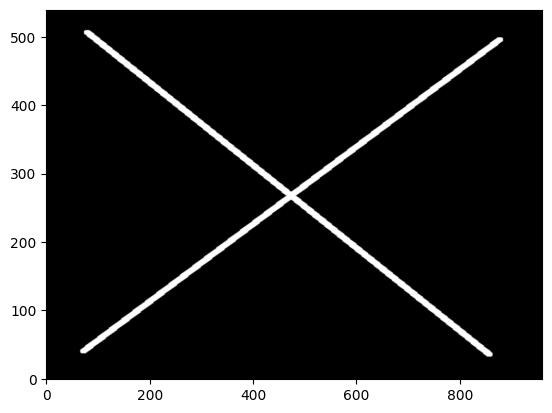

In [15]:
plt.imshow(pattern, cmap='gray',origin='lower', aspect='auto')

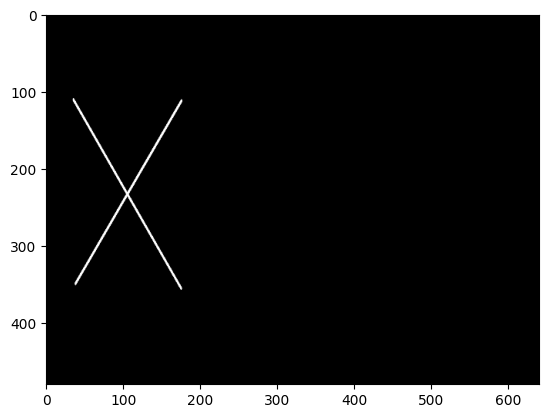

In [16]:
plt.imshow(im_dst.transpose(1,0,2), cmap='gray')

In [17]:
np.unravel_index(np.argmax(im_dst, axis=None), im_dst.shape)

(35, 110, 0)

In [18]:


screen = pygame.display.set_mode((secondary_screen_width, secondary_screen_height), pygame.FULLSCREEN, display=0)

image_surface = pygame.surfarray.make_surface(pattern)
screen.blit(image_surface, (0, 0))  # Draw the surface onto the screen
pygame.display.update()  # Update the display

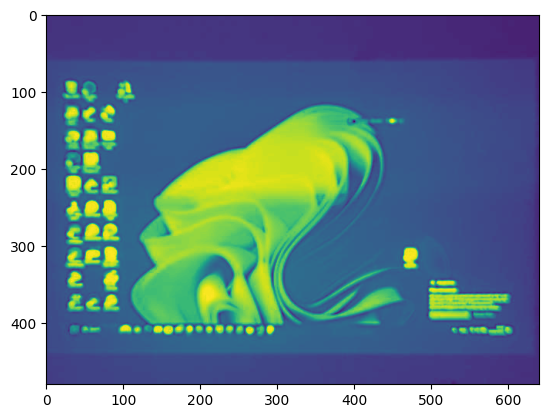

In [19]:
for i in range(5):
    ret, frame = cap.read()
if not ret:
    print("Failed to grab frame")
else:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

plt.imshow(frame)

In [20]:
# find the max value in the image 
np.unravel_index(np.argmax(frame, axis=None), frame.shape)

(122, 81)

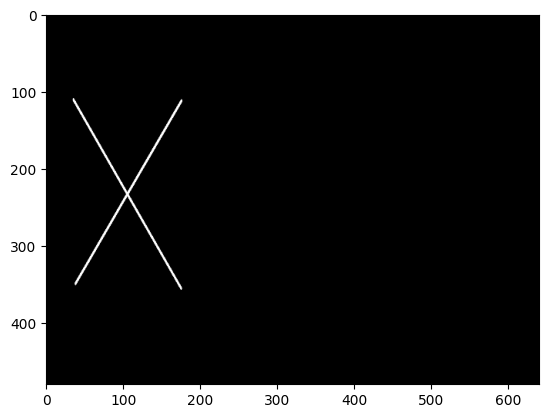

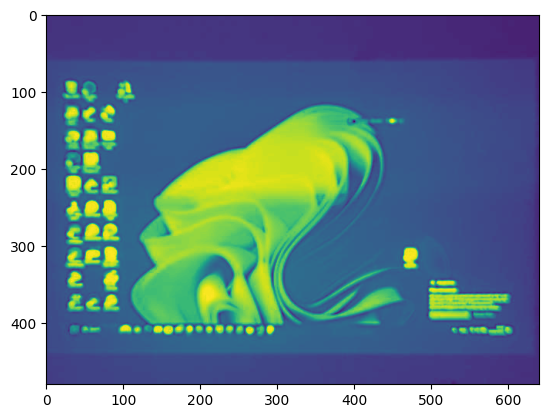

In [21]:
plt.imshow(im_dst.transpose(1,0,2))
plt.show()
plt.imshow(frame.reshape(frame.shape[0],frame.shape[1],1))


In [22]:
dst_mask = (im_dst.transpose(1,0,2).sum(-1) != 0).astype(np.uint8)
# add third dimension
d = np.stack([dst_mask*0,dst_mask*255,dst_mask*0],axis=-1)

frame_mask = (frame > 220).astype(np.uint8)
f = np.stack([frame_mask*0,frame_mask*0,frame_mask*255],axis=-1)

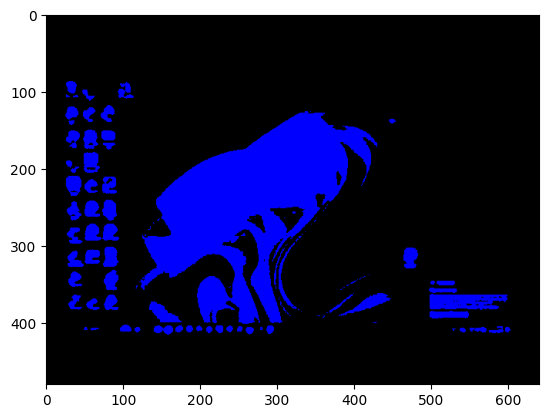

In [23]:
plt.imshow(f)

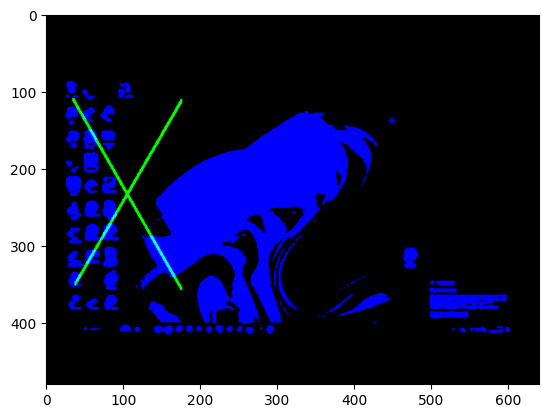

In [24]:
plt.imshow(f+d)

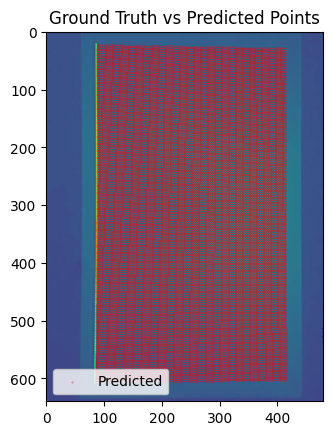

In [25]:
import cv2
import matplotlib.pyplot as plt

# Warp original points
warped_points_pred = cv2.perspectiveTransform(original_points.reshape(-1, 1, 2).astype(np.float32), H)

# Plot on the captured image
# plt.imshow(new_points, cmap='gray')
# plt.scatter(new_points[:, 0], new_points[:, 1], c='blue', label='Ground Truth')
plt.imshow(caps_y[0].T)
plt.scatter(warped_points_pred[:, 0, 0], warped_points_pred[:, 0, 1], c='red', label='Predicted', s=0.05)
plt.legend()
plt.title('Ground Truth vs Predicted Points')
plt.show()

In [26]:
# inverse new points
H_inv = np.linalg.pinv(H)

H_back, _ = cv2.findHomography(new_points, original_points, cv2.RANSAC)

# Warp original points
warped_points_pred = cv2.perspectiveTransform(new_points.reshape(-1, 1, 2).astype(np.float32), H_back)


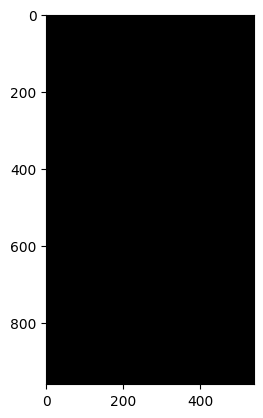

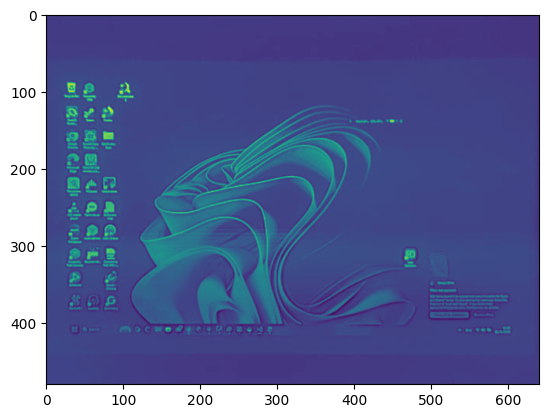

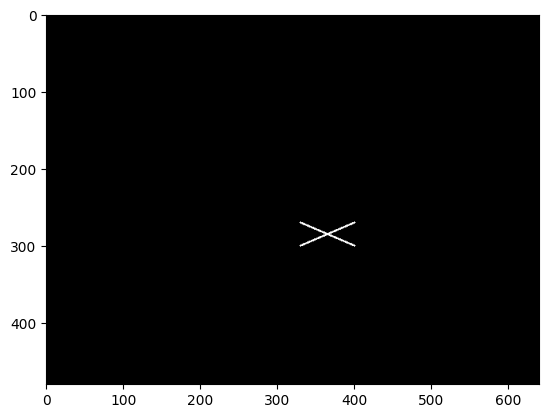

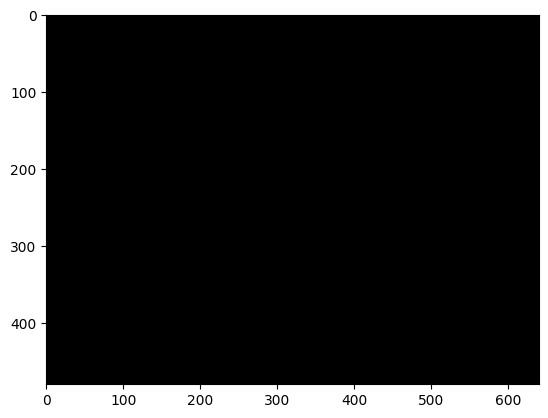

In [27]:
# H_inv = np.linalg.pinv(H)
# H_back, _ = cv2.findHomography(new_points, original_points, cv2.RANSAC)

# draw x in proj_x
height, width = 640, 480
array = np.zeros((height, width), dtype=np.uint8)
x_size, y_size = 120, 160  # Width and height of the "X" region

# Calculate the centered coordinates
x_center, y_center = width // 2, height // 2
x_start = x_center - x_size // 2 + 90
y_start = y_center - y_size // 2 + 90
x_end = x_center + x_size // 2
y_end = y_center + y_size // 2


# Draw the "X" using cv2.line
cv2.line(array, (x_start, y_start), (x_end, y_end), 255, 2)  # Main diagonal
cv2.line(array, (x_end, y_start), (x_start, y_end), 255, 2)  # Anti-diagonal

proj_x = np.stack([array,array,array],axis=-1)
    
im_src =  cv2.warpPerspective(  proj_x, H_inv, (pattern.shape[0], pattern.shape[1]) ).transpose(1,0,2)
#cv2.warpPerspective(  proj_x.transpose(1,0,2), H_back, (pattern.shape[1], pattern.shape[0]))


screen = pygame.display.set_mode((secondary_screen_width, secondary_screen_height), pygame.FULLSCREEN, display=0)

image_surface = pygame.surfarray.make_surface(im_src)
screen.blit(image_surface, (0, 0))  # Draw the surface onto the screen
pygame.display.update()  # Update the display

time.sleep(1)
for i in range(5):
    ret, frame = cap.read()
if not ret:
    print("Failed to grab frame")
else:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

plt.imshow(im_src.transpose(1,0,2))

plt.show()

plt.imshow(frame)

plt.show()

plt.imshow(proj_x.transpose(1,0,2))

plt.show()

im_dst = cv2.warpPerspective(  im_src.transpose(1,0,2), H, (caps_x.shape[1], caps_x.shape[2]))
plt.imshow(im_dst.transpose(1,0,2))

In [28]:
H_back

array([[-7.05411201e-02,  3.24836850e+00, -6.00628016e+01],
       [ 3.20137261e+00, -1.57173553e-02, -2.75009856e+02],
       [-5.06657763e-05, -1.37486472e-05,  1.00000000e+00]])

In [29]:
H_inv

array([[-5.93399485e-02,  3.32758831e+00, -7.00383540e+01],
       [ 3.25401030e+00,  1.89754214e-02, -2.88521453e+02],
       [-4.10139358e-05,  2.44163007e-05,  1.00307869e+00]])

In [30]:
positions

[((0, 0), (86, 20)),
 ((0, 10), (89, 21)),
 ((0, 20), (92, 22)),
 ((0, 30), (95, 22)),
 ((0, 40), (98, 22)),
 ((0, 50), (101, 22)),
 ((0, 60), (104, 22)),
 ((0, 70), (108, 22)),
 ((0, 80), (111, 22)),
 ((0, 90), (114, 22)),
 ((0, 100), (117, 22)),
 ((0, 110), (120, 22)),
 ((0, 120), (123, 22)),
 ((0, 130), (126, 22)),
 ((0, 140), (129, 22)),
 ((0, 150), (132, 22)),
 ((0, 160), (135, 21)),
 ((0, 170), (138, 23)),
 ((0, 180), (141, 23)),
 ((0, 190), (144, 23)),
 ((0, 200), (147, 23)),
 ((0, 210), (150, 23)),
 ((0, 220), (154, 21)),
 ((0, 230), (157, 21)),
 ((0, 240), (160, 22)),
 ((0, 250), (163, 22)),
 ((0, 260), (166, 22)),
 ((0, 270), (169, 23)),
 ((0, 280), (172, 21)),
 ((0, 290), (175, 22)),
 ((0, 300), (178, 22)),
 ((0, 310), (181, 23)),
 ((0, 320), (184, 23)),
 ((0, 330), (187, 24)),
 ((0, 340), (191, 24)),
 ((0, 350), (194, 23)),
 ((0, 360), (196, 23)),
 ((0, 370), (200, 22)),
 ((0, 380), (203, 23)),
 ((0, 390), (205, 23)),
 ((0, 400), (209, 23)),
 ((0, 410), (211, 23)),
 ((0, 42

In [31]:
warped_points_pred

array([[[-1.1673756e+00, -6.1872164e-03]],

       [[ 1.8838156e+00,  9.6284389e+00]],

       [[ 4.9360232e+00,  1.9266275e+01]],

       ...,

       [[ 1.9290673e+03,  1.0521436e+03]],

       [[ 1.9291514e+03,  1.0622006e+03]],

       [[ 1.9292074e+03,  1.0689070e+03]]], dtype=float32)

In [32]:

pattern = np.zeros((secondary_screen_width//scale, secondary_screen_height//scale,3),dtype=np.uint8)

screen = pygame.display.set_mode((secondary_screen_width, secondary_screen_height), pygame.FULLSCREEN, display=0)

image_surface = pygame.surfarray.make_surface(pattern)
screen.blit(image_surface, (0, 0))  # Draw the surface onto the screen
pygame.display.update()  # Update the display

In [33]:

scale=1
screen = pygame.display.set_mode((secondary_screen_width, secondary_screen_height), pygame.FULLSCREEN, display=0)

pattern = np.zeros((secondary_screen_width//scale, secondary_screen_height//scale,3),dtype=np.uint8) 

image_surface = pygame.surfarray.make_surface(pattern)
screen.blit(image_surface, (0, 0))  # Draw the surface onto the screen
pygame.display.update()  # Update the display

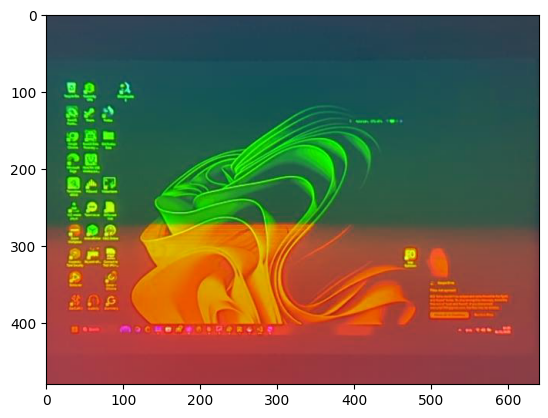

In [34]:
ret, frame = cap.read()
plt.imshow(frame)

In [35]:
import cv2.aruco as aruco

def find_rectangles(frame):
    blurred = cv2.GaussianBlur(frame, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    rectangles = []
    for contour in contours:
        # Approximate the contour
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Check if it's a rectangle
        if len(approx) == 4 and cv2.isContourConvex(approx):
            # Calculate the aspect ratio and area
            area = cv2.contourArea(approx)
            if area > 100:  # Filter small shapes
                # check if the rectangle is black
                x, y, w, h = cv2.boundingRect(approx)
                if frame[y:y+h, x:x+w].mean() < 200:
                    rectangles.append(approx)

    return rectangles    

def find_rect_centers(rectangles):
    rect_mid = []
    for rect in rectangles:
        rect_mid.append(rect.mean(0).astype(int)[0])
    return np.array(rect_mid)

def find_rect_lines(approx):
    a=approx[:,:,0].max()
    b=approx[:,:,0].min()
    c=approx[:,:,1].max()
    d=approx[:,:,1].min()
    ba = np.arange(b,a)
    cd = np.arange(d,c)
    line_1 = np.array(list(zip(ba,np.ones_like(ba)*d)))
    line_2 = np.array(list(zip(ba,np.ones_like(ba)*c)))
    line_3 = np.array(list(zip(np.ones_like(cd)*b,cd)))
    line_4 = np.array(list(zip(np.ones_like(cd)*a,cd)))
    return line_1,line_2,line_3,line_4

    # Initialize ArUco dictionary and detector parameters
parameters = aruco.DetectorParameters()   
aruco_dict_type = cv2.aruco.DICT_6X6_250 # Change dictionary type if needed
marker_length = 0.05  # Marker length in meters (adjust as needed)
aruco_dict = cv2.aruco.getPredefinedDictionary(aruco_dict_type)


import pickle
(cameraMatrix, dist) = pickle.load(open( "calibration.pkl", "rb" ))

def find_aurco(gray):

    # Detect ArUco markers
    detector = aruco.ArucoDetector(aruco_dict, parameters)
    corners, ids, _ = detector.detectMarkers(gray)

    frame = None
    
    if ids is not None:
        # Draw detected markers
        frame = aruco.drawDetectedMarkers(np.zeros([gray.shape[0],gray.shape[1],3]), corners, ids)

        # Estimate pose of each marker
    return frame


In [55]:
for ww in range(1000):
    for i in range(2):
        ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
    else:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    screen = pygame.display.set_mode((secondary_screen_width, secondary_screen_height), pygame.FULLSCREEN, display=0)

    # pattern = np.zeros((secondary_screen_width//scale, secondary_screen_height//scale,3),dtype=np.uint8) 

    # rectangles = find_rectangles(frame)
    # # print(rect_mids)
    # z = np.zeros_like(frame)
    # for rect in rectangles:
    #     line_s = find_rect_lines(rect)
    #     for line in line_s:
    #         z[line[:,1],line[:,0]] = 255

    # z = np.stack([z,z,z],axis=-1)

            # warped_points_pred = cv2.perspectiveTransform(line.reshape(-1, 1, 2).astype(np.float32), H_inv).astype(int)
            # if warped_points_pred.min() > 0 and warped_points_pred[:,0,1].max()\
            #       < pattern.shape[0] and warped_points_pred[:,0,0].max() < pattern.shape[1]:
            #         pattern[warped_points_pred[:,0,1],warped_points_pred[:,0,0]] = 255
            # warped_points_pred = find_nearest_or_interpolate(rect_mid).astype(int)
            # print(warped_points_pred)
            # pattern[warped_points_pred[1]:warped_points_pred[1]+10,warped_points_pred[0]:+warped_points_pred[0]+10,:] = 255

    edges = find_aurco(frame)
    if edges is None:
        continue
    z_warp =  cv2.warpPerspective(  edges.transpose(1,0,2), H_inv, (pattern.shape[0], pattern.shape[1]) ).transpose(1,0,2)
    # im_src =  cv2.warpPerspective(  proj_x, H_inv, (pattern.shape[0], pattern.shape[1]) ).transpose(1,0,2)

    image_surface = pygame.surfarray.make_surface(z_warp)
    screen.blit(image_surface, (0, 0))  # Draw the surface onto the screen
    pygame.display.update()  # Update the display




KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


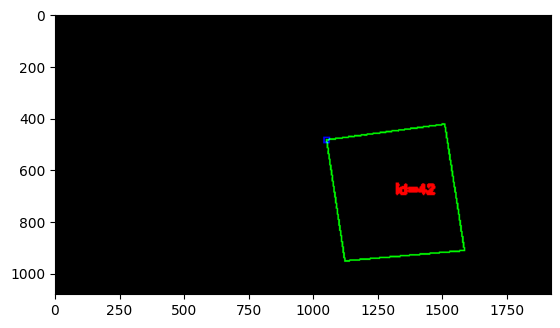

In [57]:
plt.imshow(z_warp.transpose(1,0,2))

In [93]:
edges.shape

(640, 480, 3)

In [95]:
proj_x.shape

(640, 480, 3)

In [48]:
plt.imshow(frame+edges[:,:,1])

TypeError: 'NoneType' object is not subscriptable

In [43]:
line_s = find_rect_lines(rect)
z = np.zeros_like(frame)
for line in line_s:
    z[line[:,1],line[:,0]] = 255

z = np.stack([z,z,z],axis=-1)
z_warp =  cv2.warpPerspective(  z, H_inv, (pattern.shape[0], pattern.shape[1]) ).transpose(1,0,2)



UnboundLocalError: local variable 'frame' referenced before assignment

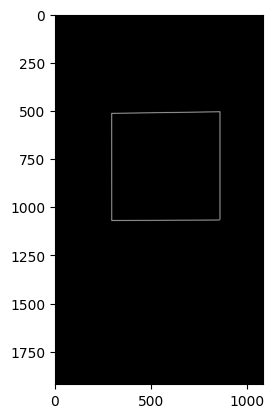

In [ ]:
plt.imshow(z_warp)

In [ ]:
 cv2.perspectiveTransform(line.reshape(-1, 1, 2).astype(np.float32), H_back).astype(int)

In [140]:
warped_points_pred = cv2.perspectiveTransform(line.reshape(-1, 1, 2).astype(np.float32), H_back).astype(int)


In [ ]:
line

In [ ]:
new_points

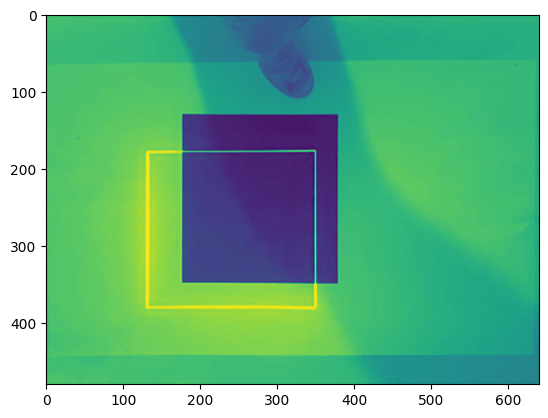

In [47]:
plt.imshow(frame)
# plt.scatter(np.array(rect_mids)[:,0],np.array(rect_mids)[:,1])

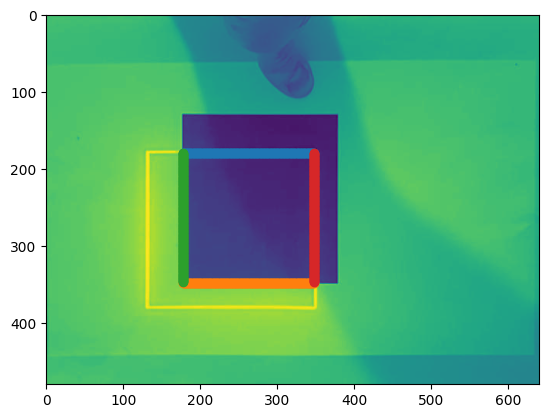

In [ ]:
plt.imshow(frame)
rectangles = find_rectangles(frame)
line_1,line_2,line_3,line_4 = find_rect_lines(rectangles[0])
plt.scatter(line_1[:,0],line_1[:,1])
plt.scatter(line_2[:,0],line_2[:,1])
plt.scatter(line_3[:,0],line_3[:,1])
plt.scatter(line_4[:,0],line_4[:,1])


In [ ]:
approx
# connect the rectangle points


In [ ]:
x, y, w, h = cv2.boundingRect(approx)
# connect the points of the rectangle
np.arange(y,x,10)
np.arange(w,h,10)




In [ ]:
output_image = frame.copy()
plt.imshow(cv2.drawContours(output_image, rectangles, -1, (0, 255, 0), 3))
plt.scatter(np.array(rect_mid)[:,0,0],np.array(rect_mid)[:,0,1])


In [56]:
np.save('H_back.npy',H_back)
np.save('H.npy',H)

In [ ]:
plt.imshow(pattern.transpose(1,0,2))

In [ ]:
# import numpy as np
# H_back = np.load('H_back.npy')
# H = np.load('H.npy')

## nearest neighboor

In [120]:
import numpy as np
from scipy.spatial import KDTree

# Define origin points (2D points)


# Build a KDTree for efficient nearest-neighbor search
kdtree = KDTree(new_points)

# Function to find the nearest point or interpolate
def find_nearest_or_interpolate(new_point):
    # Find the nearest origin point
    dist, idx = kdtree.query(new_point)

    if dist == 0:
        # Exact match found
        nearest_origin = new_points[idx]
        associated_target = original_points[idx]
        return associated_target
    else:
        # Interpolate between the two nearest points
        dists, indices = kdtree.query(new_point, k=2)  # Get two nearest neighbors
        p1, p2 = new_points[indices]
        t1, t2 = original_points[indices]
        
        # Compute weights for interpolation
        w1 = 1 / dists[0]
        w2 = 1 / dists[1]
        total_weight = w1 + w2
        w1 /= total_weight
        w2 /= total_weight
        
        # Interpolate target point
        interpolated_target = w1 * t1 + w2 * t2
        return interpolated_target


In [ ]:
warped_points_pred

## use dnn to convert

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

    